In [61]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from traffic.core import Traffic

#with open('', 'rb') as f:
#df_original = Traffic.from_file('./resampled/combined_traffic_resampled_200.pkl')
df_2 = Traffic.from_file('./OpenSky_EGLL_EHAM_trajectories.pkl')
#df_original = df_original + df_2
import pandas as pd
import numpy as np
from geopy.distance import geodesic

In [2]:
len(df_2)
#len(df_original)

11385

In [3]:
import traffic
traffic.config_file

PosixPath('/home/olavfpl/.config/traffic/traffic.conf')

In [62]:

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
    # clustering
print("Clustering...")

df_2

Clustering...


,count
flight_id,
3848da_FWWQA_20210615_170605,2559
484559_KLM16K_20230502_162819,2559
48455a_KLM1002_20220708_074804,2559
48455a_KLM1002_20220713_101350,2559
48455a_KLM1002_20220720_075552,2559
48455a_KLM1002_20220908_081147,2559
48455a_KLM1002_20220910_085449,2559
48455a_KLM1002_20221027_075852,2559
48455a_KLM1002_20221103_091301,2559


In [63]:
#df_test = df_2.clean_invalid().drop_duplicates().filter().resample(200).eval()  # multiprocessed (watch your RAM usage!)

df_test = df_2.drop_duplicates().resample(200).eval()
df_test

,count
flight_id,
3848da_FWWQA_20210615_170605,200
484559_KLM16K_20230502_162819,200
48455a_KLM1002_20220708_074804,200
48455a_KLM1002_20220713_101350,200
48455a_KLM1002_20220720_075552,200
48455a_KLM1002_20220908_081147,200
48455a_KLM1002_20220910_085449,200
48455a_KLM1002_20221027_075852,200
48455a_KLM1002_20221103_091301,200


# Density

findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.


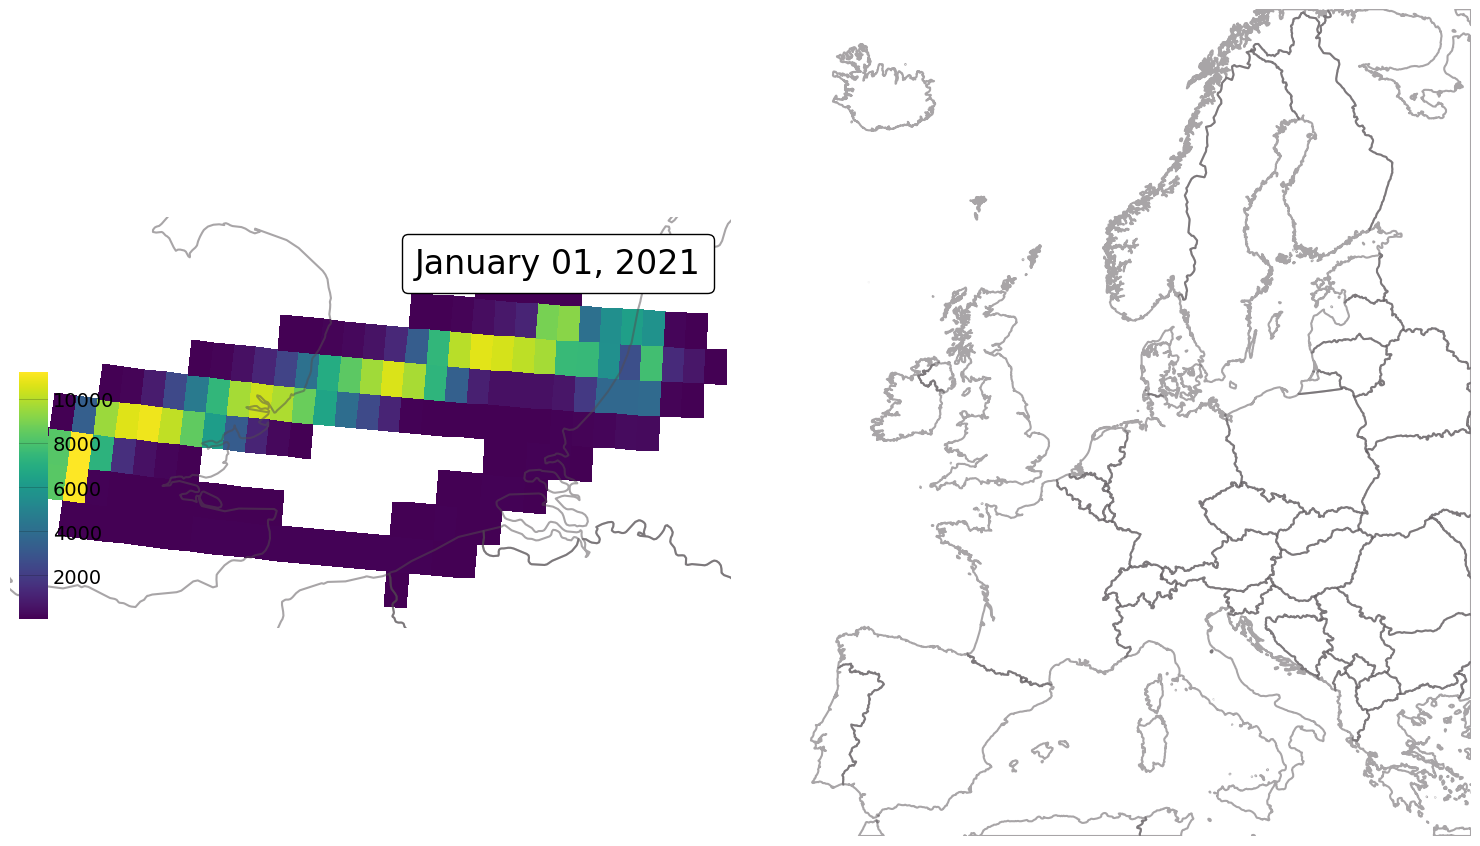

In [69]:
import matplotlib.pyplot as plt

from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from cartopy.crs import EuroPP, PlateCarree
from cartes.utils.features import countries, ocean


with plt.style.context("traffic"):

    fig = plt.figure(figsize=(15, 10), frameon=False)
    ax = fig.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))

    for ax_ in ax:
        ax_.add_feature(countries(scale="10m", linewidth=1.5))

    vmax = None  # this trick will keep the same colorbar scale for both maps

    for i, data in enumerate([df_test]):
        # Aggregate and query the data, then convert to xarray
        data_xarray = data.agg_latlon(
            # 10 points per integer lat/lon
            resolution=dict(latitude=30, longitude=),
            # count the number of flights
            flight_id="nunique"
        ).query(f"flight_id > 10").to_xarray()

        # Sort the DataArray by latitude and longitude
        data_xarray = data_xarray.sortby(['latitude', 'longitude'])

        # Plot the data using pcolormesh
        cax = data_xarray.flight_id.plot.pcolormesh(
            ax=ax[i],
            cmap="viridis",
            transform=PlateCarree(),
            vmax=vmax,
            add_colorbar=False,
        )

        cbaxes = inset_axes(ax[i], "4%", "60%", loc=3)
        cb = fig.colorbar(cax, cax=cbaxes)

        # Keep this value to scale the colorbar for the second day
        vmax = cb.vmax

        text = AnchoredText(
            f"{data.start_time:%B %d, %Y}",
            loc=1,
            prop={"size": 24, "fontname": "Ubuntu"},
            frameon=True,
        )
        text.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax[i].add_artist(text)

    fig.set_tight_layout(True)

    plt.show()

In [ ]:
df_2 = df_2.drop_duplicates().resample(200).eval()
#df_2.to_pickle("other_features_200.pkl")

In [167]:
df_test = Traffic(df_2.data[['flight_id', 'icao24', 'timestamp', 'altitude', 'ADEP', 'ADES', 'groundspeed', 'track', 'vertical_rate', 'timedelta']])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


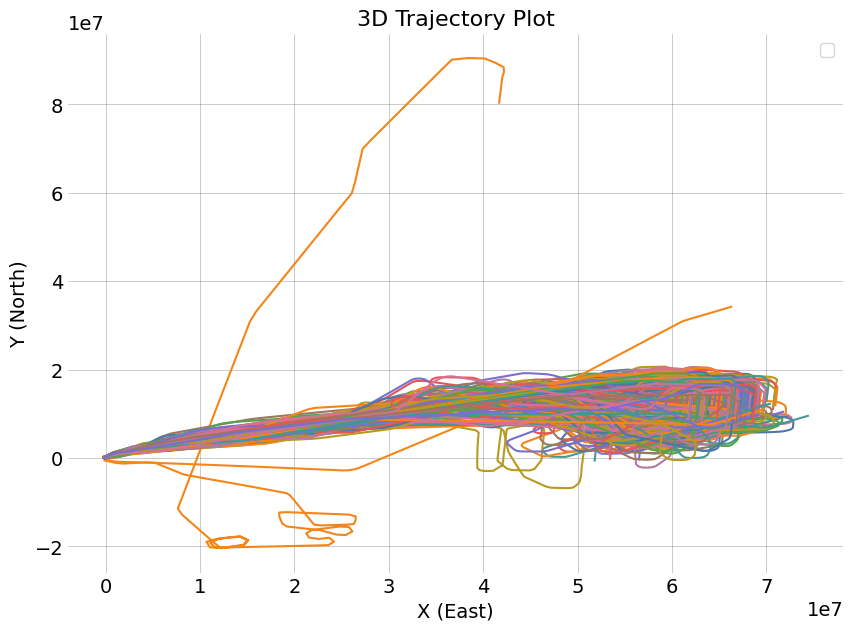

In [180]:
def plot_trajectory(traffic):
    """
    Plots a 3D trajectory based on groundspeed, track, and vertical rate.
    
    Parameters:
    - groundspeed: List or array of groundspeed values (in m/s or appropriate units)
    - track: List or array of track values (in degrees, where 0 = North, 90 = East)
    - vertical_rate: List or array of vertical rate values (in m/s)
    - time_interval: Time interval between each point (in seconds), default is 1 second
    """
    # Convert track angles from degrees to radians for trigonometric calculations
    #from cartes.crs import Lambert93
    with plt.style.context("traffic"):
        fig, ax = plt.subplots()

        for (i, flight) in enumerate(traffic):
            if i == 400:
                break
            track = flight.data['track']
            groundspeed = flight.data['groundspeed']
            time_interval = flight.data['timedelta']
            
            #flight.plot(ax)
            track_rad = np.radians(track)
            
            # Calculate the change in position for each time step (horizontal velocity components)
            dx = groundspeed * np.sin(track_rad) * time_interval  # Change in x-direction (East)
            dy = groundspeed * np.cos(track_rad) * time_interval  # Change in y-direction (North)
            
            # Integrate to get the cumulative positions
            x = np.cumsum(dx)  # Cumulative sum of changes in x-direction
            y = np.cumsum(dy)  # Cumulative sum of changes in y-direction
            
            # Integrate vertical rate to get altitude (z)
            #z = np.cumsum(vertical_rate * time_interval)  # Cumulative sum of altitude changes
            
            # Time array for plotting
            time = np.arange(len(groundspeed)) * time_interval
            
            # 3D Plot

            
            ax.plot(x, y)
        ax.set_xlabel('X (East)')
        ax.set_ylabel('Y (North)')
        #ax.set_zlabel('Altitude (m)')
        ax.set_title('3D Trajectory Plot')
        ax.legend()
        
        plt.show()

a = df_test.query("flight_id == '3848da_FWWQA_20210615_170605'")
plot_trajectory(df_test)

In [6]:
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from cartes.crs import EuroPP

t_gmm = df_2.drop_duplicates().clustering(
    nb_samples=15,
    projection=EuroPP(),
    features=["x", "y", "track_unwrapped"],
    clustering=GaussianMixture(n_components=19),
    transform=StandardScaler(),
).fit_predict()

dict(t_gmm.groupby(["cluster"]).agg({"flight_id": "nunique"}).flight_id)

{0: 1635,
 1: 459,
 2: 697,
 3: 1949,
 4: 308,
 5: 913,
 6: 81,
 7: 252,
 8: 850,
 9: 1411,
 10: 203,
 11: 239,
 12: 386,
 13: 1,
 14: 29,
 15: 396,
 16: 518,
 17: 222,
 18: 836}

In [12]:
from itertools import islice, cycle

from cartes.utils.features import countries

n_clusters = 1 + t_gmm.data.cluster.max()

# -- dealing with colours --

color_cycle = cycle(
    "#a6cee3 #1f78b4 #b2df8a #33a02c #fb9a99 #e31a1c "
    "#fdbf6f #ff7f00 #cab2d6 #6a3d9a #ffff99 #b15928".split()
)
colors = list(islice(color_cycle, n_clusters))
colors.append("#aaaaaa")  # color for outliers, if any

# -- dealing with the grid --

nb_cols = 3
nb_lines = (1 + n_clusters) // nb_cols + (((1 + n_clusters) % nb_cols) > 0)

with plt.style.context("traffic"):

    fig, ax = plt.subplots(
        nb_lines, nb_cols, figsize=(10, 15), subplot_kw=dict(projection=EuroPP())
    )

    for cluster in range(1, n_clusters):
        ax_ = ax[(cluster + 1) // nb_cols][(cluster + 1) % nb_cols]
        ax_.add_feature(countries())
        #print(t_gmm.query(f"cluster == {1}"))
        t_gmm.query(f"cluster == {cluster}").plot(
            ax_, color=colors[cluster], alpha=0.1 if cluster == -1 else 1
        )
        ax_.set_global()

plt.show()

AttributeError: 'Axes' object has no attribute 'add_feature'

In [134]:
import traffic
from traffic.data import opensky

print(opensky.trino_client.query("show tables"))


                      Table
0                 flarm_raw
1             flights_data4
2             flights_data5
3      identification_data4
4  operational_status_data4
5            position_data4
6    rollcall_replies_data4
7       state_vectors_data4
8            velocity_data4


In [138]:
print(opensky.trino_client.query("describe state_vectors_data4"))
print(opensky.trino_client.query("describe velocity_data4"))
print(opensky.trino_client.query("describe flights_data4"))
print(opensky.trino_client.query("describe flights_data5"))
print(opensky.trino_client.query("describe position_data4"))
print(opensky.trino_client.query("describe operational_status_data4"))
print(opensky.trino_client.query("describe identification_data4"))

           Column            Type          Extra Comment
0            time         integer                       
1          icao24         varchar                       
2             lat          double                       
3             lon          double                       
4        velocity          double                       
5         heading          double                       
6        vertrate          double                       
7        callsign         varchar                       
8        onground         boolean                       
9           alert         boolean                       
10            spi         boolean                       
11         squawk         varchar                       
12   baroaltitude          double                       
13    geoaltitude          double                       
14  lastposupdate          double                       
15    lastcontact          double                       
16        serials  array(intege

In [136]:
print(opensky.trino_client.query("describe operational_status_data4"))

FINISHED: : 100% [00:00, 976%/s]
DOWNLOAD: 34.0lines [00:00, 31.0klines/s]

                             Column  \
0                           sensors   
1                            rawmsg   
2                            icao24   
3                           mintime   
4                           maxtime   
5                          msgcount   
6                       subtypecode   
7                    unknowncapcode   
8                     unknownopcode   
9                hasoperationaltcas   
10                      has1090esin   
11    supportsairreferencedvelocity   
12                    haslowtxpower   
13        supportstargetstatereport   
14       supportstargetchangereport   
15                         hasuatin   
16                             nacv   
17                   nicsupplementc   
18        hastcasresolutionadvisory   
19             hasactiveidentswitch   
20                usessingleantenna   
21            systemdesignassurance   
22                 gpsantennaoffset   
23                   airplanelength   
24                    air

In [154]:
df = df_2.drop_duplicates().resample(200).eval()
df

,count
flight_id,
3c1baf_BCS6927_20210118_134424,200
484f06_KLM55W_20210117_171711,200
4caca6_BCS6927_20210104_141105,200
485875_KLM55W_20210112_171837,200
485871_KLM66Q_20210105_175534,200
485871_KLM55W_20210106_171305,200
4855d0_KLM66Q_20210112_180153,200
485339_CND972P_20210221_195821,200
485207_KLM55W_20210110_172721,200


In [145]:
from traffic.data import eurofirs
eurofirs.head()

,geometry,designator,name,type,upper,lower,latitude,longitude
0,"POLYGON ((6.19247 49.96404, 6.19404 49.96043, ...",EBBU,BRUSSELS FIR,FIR,195.0,0.0,50.628406,4.600560
1,"POLYGON ((6.9056 45.67116, 6.90687 45.67508, 6...",LIMM,MILANO FIR,FIR,195.0,0.0,45.030624,10.499386
2,"POLYGON ((6.12122 46.25472, 6.12454 46.25131, ...",LFMM,MARSEILLE FIR,FIR,195.0,0.0,42.845677,5.925558
3,"POLYGON ((-13 45, -13 43, -15 42, -15 36.5, -1...",LPPO,SANTA MARIA OCEANIC FIR,FIR,inf,0.0,34.190600,-29.363399
4,"POLYGON ((30.56583 51.30833, 30.56722 51.31389...",UKBV,KYIV FIR,FIR,275.0,0.0,50.086590,30.888969


In [153]:
from traffic.data import eurofirs

from shapely.geometry import Point


# Create a spatial index for the FIRs to speed up lookups
eurofirs_sindex = eurofirs.data.sindex

def find_fir_by_coordinates_optimized(lon, lat):
    """
    Finds the FIR polygon that contains the given coordinates using spatial indexing.
    
    Parameters:
    - lon (float): Longitude of the point.
    - lat (float): Latitude of the point.
    
    Returns:
    - FIR name (str): The name of the FIR polygon that contains the point, or None if not found.
    """
    # Create a Shapely Point from the coordinates
    point = Point(lon, lat)
    
    # Use the spatial index to find possible matches
    possible_matches_index = list(eurofirs_sindex.intersection(point.bounds))
    possible_matches = eurofirs.data.iloc[possible_matches_index]

    # Check if any of the possible matches contain the point
    for idx, row in possible_matches.iterrows():
        if row['geometry'].contains(point):
            return row['name']  # Assuming 'name' holds the FIR name
    
    return None

# Apply the optimized function to each row in the DataFrame
df['FIR'] = df.apply(lambda row: find_fir_by_coordinates_optimized(row['longitude'], row['latitude']), axis=1)

# Show the resulting DataFrame with the FIR name
print(df)

                    timestamp  icao24 callsign   latitude  longitude  \
0   2021-01-18 13:44:24+00:00  3c1baf  BCS6927  51.464989  -0.455856   
1   2021-01-18 13:44:37+00:00  3c1baf  BCS6927  51.465225  -0.470037   
2   2021-01-18 13:44:51+00:00  3c1baf  BCS6927  51.466095  -0.485477   
3   2021-01-18 13:45:04+00:00  3c1baf  BCS6927  51.467735  -0.500031   
4   2021-01-18 13:45:17+00:00  3c1baf  BCS6927  51.470016  -0.514755   
..                        ...     ...      ...        ...        ...   
195 2021-01-08 12:54:15+00:00  a8c006  GTI8012  52.271851   4.692459   
196 2021-01-08 12:54:27+00:00  a8c006  GTI8012  52.275970   4.703140   
197 2021-01-08 12:54:38+00:00  a8c006  GTI8012  52.279861   4.713211   
198 2021-01-08 12:54:50+00:00  a8c006  GTI8012  52.283842   4.723650   
199 2021-01-08 12:55:02+00:00  a8c006  GTI8012  52.287892   4.734087   

     altitude  ADEP  ADES  groundspeed       track  vertical_rate  \
0        50.0  EGLL  EHAM        154.0  270.744059         1664.0 

In [158]:
df.cumulative_distance().eval().data

,timestamp,icao24,callsign,latitude,longitude,altitude,ADEP,ADES,groundspeed,track,...,hour,month,day_of_week,track_cos,track_sin,timedelta,track_unwrapped,cumdist,compute_gs,compute_track
0,2021-01-18 13:44:24+00:00,3c1baf,BCS6927,51.464989,-0.455856,50.0,EGLL,EHAM,154.0,270.744059,...,13.733333,1,0,0.012986,-0.999916,0.0,270.744059,0.000000,147.402502,271.535945
1,2021-01-18 13:44:37+00:00,3c1baf,BCS6927,51.465225,-0.470037,950.0,EGLL,EHAM,149.0,271.921956,...,13.733333,1,0,0.033538,-0.999437,13.0,271.921956,0.532287,147.402502,271.535945
2,2021-01-18 13:44:51+00:00,3c1baf,BCS6927,51.466095,-0.485477,2025.0,EGLL,EHAM,149.0,276.934349,...,13.733333,1,0,0.120732,-0.992685,27.0,276.934349,1.114003,149.584205,275.159263
3,2021-01-18 13:45:04+00:00,3c1baf,BCS6927,51.467735,-0.500031,2875.0,EGLL,EHAM,160.0,281.870265,...,13.750000,1,0,0.205696,-0.978616,40.0,281.870265,1.668901,153.664126,280.233908
4,2021-01-18 13:45:17+00:00,3c1baf,BCS6927,51.470016,-0.514755,3600.0,EGLL,EHAM,178.0,285.679524,...,13.750000,1,0,0.270256,-0.962788,53.0,285.679524,2.238120,157.629784,283.935866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2021-01-08 12:54:15+00:00,a8c006,GTI8012,52.271851,4.692459,600.0,EGLL,EHAM,137.0,57.817368,...,12.900000,1,4,0.532620,0.846355,2300.0,57.817368,204.172545,131.885670,58.292587
196,2021-01-08 12:54:27+00:00,a8c006,GTI8012,52.275970,4.703140,450.0,EGLL,EHAM,139.0,57.907409,...,12.900000,1,4,0.531289,0.847191,2312.0,57.907409,204.637569,139.507140,57.834849
197,2021-01-08 12:54:38+00:00,a8c006,GTI8012,52.279861,4.713211,300.0,EGLL,EHAM,138.0,57.687521,...,12.900000,1,4,0.534536,0.845145,2323.0,57.687521,205.076201,143.552309,57.789299
198,2021-01-08 12:54:50+00:00,a8c006,GTI8012,52.283842,4.723650,150.0,EGLL,EHAM,138.0,58.038657,...,12.900000,1,4,0.529347,0.848405,2335.0,58.038657,205.529182,135.894124,58.123347


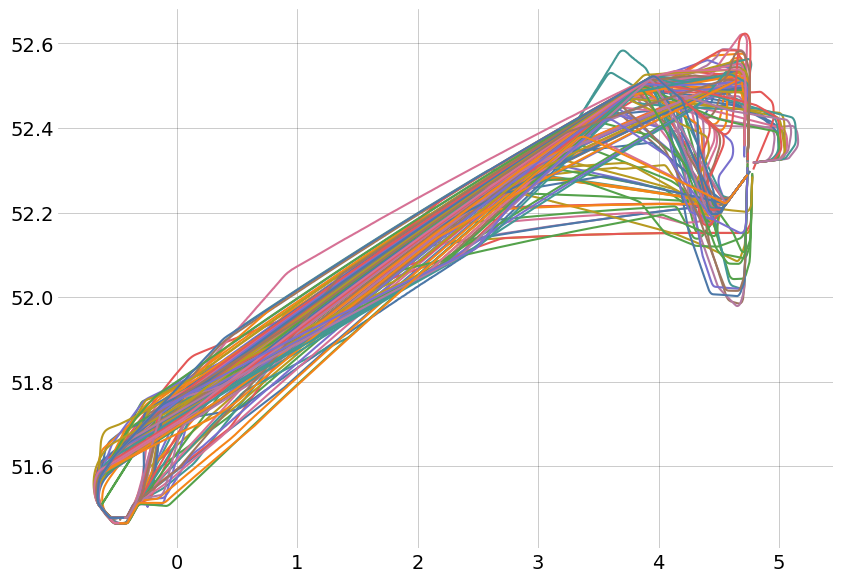

In [131]:
#df_original[df_original['flight_id'] == '300696_SIO879_20191002_150321']
from cartes.crs import Lambert93
with plt.style.context("traffic"):
    fig, ax = plt.subplots()
    for flight in df_2:
        flight.plot(ax)

plt.show()

# Add Time based features

In [11]:
df = df_original.data

# Convert timestamp to datetime if not already done
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Add time-based features (hour, day_of_week, month)
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.weekday
df['month'] = df['timestamp'].dt.month

# Apply cyclic transformations (sin and cos) for each time feature

# Hour of the day (24-hour cycle)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Day of the week (7-day cycle)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Month of the year (12-month cycle)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add time difference between consecutive rows
#df['time_diff'] = df['timestamp'].diff().dt.total_seconds()

# Add elapsed time since the start of the flight
#df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

# Drop original hour, day_of_week, and month columns to avoid redundancy
df = df.drop(columns=['hour', 'day_of_week', 'month'])

# Recreate Traffic object with the modified DataFrame
df_original = Traffic(df)


In [15]:
df_original.data

,timestamp,icao24,callsign,latitude,longitude,altitude,ADEP,ADES,flight_id,z_score,timedelta,cluster,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,time_diff,elapsed_time
0,2019-09-29 18:27:20+00:00,300164,AZA94M,52.295620,4.754490,750.0,EHAM,LIMC,300164_AZA94M_20190929_182720,-1.942287,0.0,0,-1.0,-1.836970e-16,-0.781831,0.62349,-1.0,-1.836970e-16,NaN,23450767.0
1,2019-09-29 18:27:21+00:00,300164,AZA94M,52.295341,4.753706,775.0,EHAM,LIMC,300164_AZA94M_20190929_182720,-1.940312,1.0,0,-1.0,-1.836970e-16,-0.781831,0.62349,-1.0,-1.836970e-16,1.0,23450768.0
2,2019-09-29 18:27:22+00:00,300164,AZA94M,52.295197,4.753342,825.0,EHAM,LIMC,300164_AZA94M_20190929_182720,-1.936363,2.0,0,-1.0,-1.836970e-16,-0.781831,0.62349,-1.0,-1.836970e-16,1.0,23450769.0
3,2019-09-29 18:27:23+00:00,300164,AZA94M,52.294693,4.752121,850.0,EHAM,LIMC,300164_AZA94M_20190929_182720,-1.934389,3.0,0,-1.0,-1.836970e-16,-0.781831,0.62349,-1.0,-1.836970e-16,1.0,23450770.0
4,2019-09-29 18:27:24+00:00,300164,AZA94M,52.294410,4.751430,925.0,EHAM,LIMC,300164_AZA94M_20190929_182720,-1.928465,4.0,0,-1.0,-1.836970e-16,-0.781831,0.62349,-1.0,-1.836970e-16,1.0,23450771.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4628,2021-01-25 10:11:07+00:00,ac50fa,FDX9797,45.625755,8.724174,1000.0,EHAM,LIMC,ac50fa_FDX9797_20210125_085611,-1.922541,4496.0,0,0.5,-8.660254e-01,0.000000,1.00000,0.5,8.660254e-01,1.0,65238594.0
4629,2021-01-25 10:11:08+00:00,ac50fa,FDX9797,45.626453,8.723969,1000.0,EHAM,LIMC,ac50fa_FDX9797_20210125_085611,-1.922541,4497.0,0,0.5,-8.660254e-01,0.000000,1.00000,0.5,8.660254e-01,1.0,65238595.0
4630,2021-01-25 10:11:09+00:00,ac50fa,FDX9797,45.626733,8.723900,1000.0,EHAM,LIMC,ac50fa_FDX9797_20210125_085611,-1.922541,4498.0,0,0.5,-8.660254e-01,0.000000,1.00000,0.5,8.660254e-01,1.0,65238596.0
4631,2021-01-25 10:11:10+00:00,ac50fa,FDX9797,45.627198,8.723763,1000.0,EHAM,LIMC,ac50fa_FDX9797_20210125_085611,-1.922541,4499.0,0,0.5,-8.660254e-01,0.000000,1.00000,0.5,8.660254e-01,1.0,65238597.0


In [27]:
#Categorical: ADEP, ADES, 
categorical_features = df_original.data[['flight_id','icao24','ADEP', 'ADES']]
categorical_features.drop_duplicates(inplace=True)

continuous_features = df_original.data[['flight_id', 'hour_sin', 'hour_cos','day_of_week_sin','day_of_week_cos',  'month_sin', 'month_cos']]

print(categorical_features)
print(continuous_features)

/tmp/ipykernel_464850/2715925647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_features.drop_duplicates(inplace=True)


                         flight_id  icao24  ADEP  ADES
0    300164_AZA94M_20190929_182720  300164  EHAM  LIMC
0   06a1ec_QTR8212_20200426_164433  06a1ec  EHAM  LIMC
0    300068_AZA94M_20190908_192118  300068  EHAM  LIMC
0    3000c7_AZA44M_20191013_102134  3000c7  EHAM  LIMC
0   06a1eb_QTR8202_20200316_164155  06a1eb  EHAM  LIMC
..                             ...     ...   ...   ...
0   ac10d8_FDX9798_20210315_100611  ac10d8  EHAM  LIMC
0   abed10_FDX9797_20210201_083401  abed10  EHAM  LIMC
0   ac1e56_FDX979D_20210207_204625  ac1e56  EHAM  LIMC
0   ac3857_FDX9798_20210329_093502  ac3857  EHAM  LIMC
0   ac50fa_FDX9797_20210125_085611  ac50fa  EHAM  LIMC

[6592 rows x 4 columns]
      icao24  hour_sin      hour_cos  day_of_week_sin  day_of_week_cos  \
0     300164      -1.0 -1.836970e-16        -0.781831          0.62349   
1     300164      -1.0 -1.836970e-16        -0.781831          0.62349   
2     300164      -1.0 -1.836970e-16        -0.781831          0.62349   
3     300164      -